In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import pathlib
import json

In [2]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=3, num_neurons=128, conv_neurons=32, num_layers=2):
        super(SimpleCNN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Conv2d(3, conv_neurons, kernel_size=kernel_size, stride=1, padding=1))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Intermediate layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Conv2d(conv_neurons, conv_neurons * 2, kernel_size=kernel_size, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            conv_neurons *= 2

        # Calculate the size of the flattened output
        self.flattened_size = self._get_flattened_size(3, 32, kernel_size, num_layers)

        self.fc1 = nn.Linear(self.flattened_size, num_neurons)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(num_neurons, 10)

    def _get_flattened_size(self, input_channels, input_dim, kernel_size, num_layers):
        """Dynamically calculate the flattened size after conv and pooling layers."""
        x = torch.zeros((1, input_channels, input_dim, input_dim))
        for layer in self.layers:
            x = layer(x)
        return x.numel()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Deep Ensemble Model
class DeepEnsemble:
    def __init__(self, base_model_class, num_models, *model_args, **model_kwargs):
        self.models = [base_model_class(*model_args, **model_kwargs) for _ in range(num_models)]

    def train(self, trainloader, criterion, optimizers, epochs, device):
        for epoch in range(epochs):
            for model, optimizer in zip(self.models, optimizers):
                model.train()
                for inputs, labels in trainloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

    def predict(self, inputs):
        predictions = [torch.softmax(model(inputs), dim=1) for model in self.models]
        return torch.mean(torch.stack(predictions), dim=0)

In [3]:

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Create validation set with 500 samples per class
def create_validation_set(trainset, samples_per_class):
    indices = []
    class_counts = {i: 0 for i in range(10)}
    for idx, (_, label) in enumerate(trainset):
        if class_counts[label] < samples_per_class:
            indices.append(idx)
            class_counts[label] += 1
        if all(count >= samples_per_class for count in class_counts.values()):
            break
    val_subset = Subset(trainset, indices)
    remaining_indices = [idx for idx in range(len(trainset)) if idx not in indices]
    train_subset = Subset(trainset, remaining_indices)
    return train_subset, val_subset

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:

trainset, valset = create_validation_set(trainset, 500)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Train Deep Ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_size = 5
base_model_class = SimpleCNN
ensemble = DeepEnsemble(base_model_class, ensemble_size, kernel_size=3, num_neurons=128, conv_neurons=32, num_layers=2)

# Prepare trainloader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in ensemble.models]

# Train models
ensemble.train(trainloader, criterion, optimizers, epochs=50, device=device)

# Evaluate Ensembles
ensemble.models = [model.to(device) for model in ensemble.models]
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ensemble.predict(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the ensemble on the test set: {accuracy:.2f}%")

Accuracy of the ensemble on the test set: 91.04%


Mean values: torch.Size([40]), low


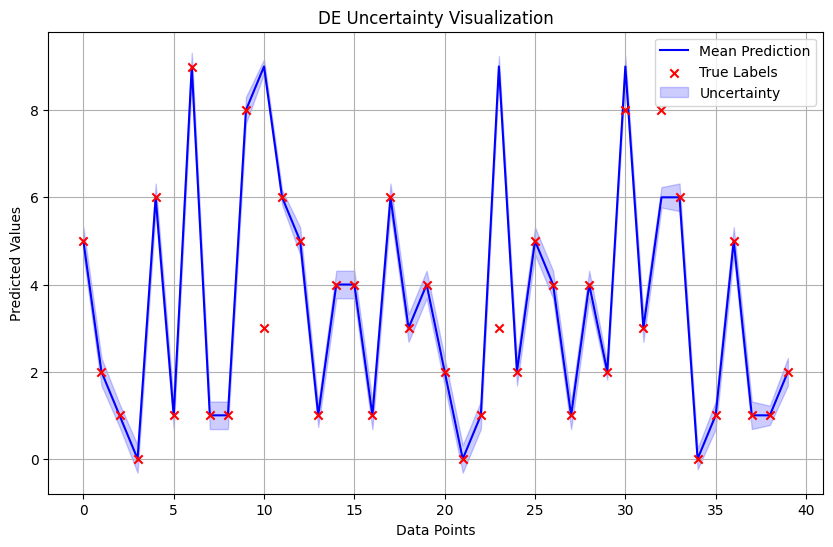

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_plot_mcdo(ensemble, inputs, labels, n_samples=50, num_data_points=40):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        mean_output = ensemble.predict(inputs)

    _, means = torch.max(mean_output, 1)
    stds = np.sqrt(mean_output.var(dim=1).detach().numpy())

    mean_values = means[:num_data_points]
    upper_bound = (means + stds)[:num_data_points]
    lower_bound = (means - stds)[:num_data_points]

    print(f"Mean values: {mean_values.shape}, low")
    x = range(num_data_points)  ]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_values, label="Mean Prediction", color="blue")
    plt.scatter(x, labels[:num_data_points], color="red", label="True Labels", marker="x", zorder=5)
    plt.fill_between(x, lower_bound, upper_bound, color="blue", alpha=0.2, label="Uncertainty")
    plt.title("DE Uncertainty Visualization")
    plt.xlabel("Data Points")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    output_dir = "./results/"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{output_dir}/de_uncertainty_plot.png")
    plt.show()


# Example call to plot uncertainties
sample_inputs, labels = next(iter(testloader))
sample_inputs = sample_inputs.to(device)
labels = labels.to(device)
make_plot_mcdo(ensemble, sample_inputs, labels, n_samples=50, num_data_points=40)